In [5]:
import warnings
import math
import pickle

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as px
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import xgboost                 as xgb
import scipy.stats             as stats
import category_encoders       as ce


from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn                              import metrics
from scipy.stats                          import ks_2samp
from scipy.stats                          import t
from sklearn.model_selection              import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.impute                       import SimpleImputer
from sklearn.metrics                      import accuracy_score, roc_auc_score, classification_report,mean_squared_error, mean_absolute_error
from sklearn.compose                      import ColumnTransformer
from sklearn.ensemble                     import RandomForestRegressor
from sklearn.tree                         import DecisionTreeRegressor
from sklearn.pipeline                     import Pipeline
from sklearn.preprocessing                import LabelEncoder, StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.decomposition                import PCA
from sklearn.linear_model                 import LogisticRegression
from scipy.stats                          import uniform

In [3]:
from Data_Understanding import data_out_of_time, data_2015_dev_ml, data_without_duplicated


df_out_of_time = data_out_of_time().copy()
data_frame = data_2015_dev_ml().copy()
df_ = data_without_duplicated().copy()



Original data_out_of_time loaded
Original data_2015_dev_ml loaded
Original data_without_duplicated loaded


In [3]:
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline

In [4]:
custom_params = {"axes.spines.right":False,"axes.spines.top":False}
sns.set_theme(style='ticks',rc=custom_params)
color_palette = ['#8f28ff','#bc7eff','#c0b0d1', '#a1b5db', '#7095db', '#636efa']

sns.set_palette(sns.color_palette(color_palette))
sns.set(rc={"axes.facecolor":"#e8e8e8","figure.facecolor":"#e8e8e8"})
sns.color_palette(color_palette)

[(0.5607843137254902, 0.1568627450980392, 1.0),
 (0.7372549019607844, 0.49411764705882355, 1.0),
 (0.7529411764705882, 0.6901960784313725, 0.8196078431372549),
 (0.6313725490196078, 0.7098039215686275, 0.8588235294117647),
 (0.4392156862745098, 0.5843137254901961, 0.8588235294117647),
 (0.38823529411764707, 0.43137254901960786, 0.9803921568627451)]

<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Data Manipulation
</div>

*As the duplicate data has already been removed in the exploratory analysis part, here we can see that we have several categorical variables that we need to transform into numerical ones. we also need to treat the outliers and clean our data. The employment time variable is the only variable that contains missing data, so let's test it and decide how we're going to treat it.*

*We need to standardize our data as it is out of scale, we will also balance our target variable.*

In [5]:
df_.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280339 entries, 0 to 749998
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               280339 non-null  datetime64[ns]
 1   index                  280339 non-null  int64         
 2   sexo                   280339 non-null  object        
 3   posse_de_veiculo       280339 non-null  object        
 4   posse_de_imovel        280339 non-null  object        
 5   qtd_filhos             280339 non-null  int64         
 6   tipo_renda             280339 non-null  object        
 7   educacao               280339 non-null  object        
 8   estado_civil           280339 non-null  object        
 9   tipo_residencia        280339 non-null  object        
 10  idade                  280339 non-null  int64         
 11  tempo_emprego          232730 non-null  float64       
 12  qt_pessoas_residencia  280339 non-null  float64  

### Data transformer

In [7]:
def modeling_schema(df):
    df = df.copy()  
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df['sexo'] = df['sexo'].map({'F': 1, 'M': 0})
    df['posse_de_veiculo'] = df['posse_de_veiculo'].map({'S': 1, 'N': 0})
    df['posse_de_imovel'] = df['posse_de_imovel'].map({'S': 1, 'N': 0})
    cat_var = df.select_dtypes(exclude='number').drop(columns=['data_ref', 'mau']).columns.tolist()
    
    lb = LabelEncoder()
    
    for var in cat_var:
        df[var] = lb.fit_transform(df[var])
        
    return df




In [8]:
df_ = modeling_schema(df_)


In [9]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280339 entries, 0 to 749998
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               280339 non-null  datetime64[ns]
 1   index                  280339 non-null  int64         
 2   sexo                   280339 non-null  int64         
 3   posse_de_veiculo       280339 non-null  int64         
 4   posse_de_imovel        280339 non-null  int64         
 5   qtd_filhos             280339 non-null  int64         
 6   tipo_renda             280339 non-null  int32         
 7   educacao               280339 non-null  int32         
 8   estado_civil           280339 non-null  int32         
 9   tipo_residencia        280339 non-null  int32         
 10  idade                  280339 non-null  int64         
 11  tempo_emprego          232730 non-null  float64       
 12  qt_pessoas_residencia  280339 non-null  float64  

<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Missing values
</div>

<Axes: >

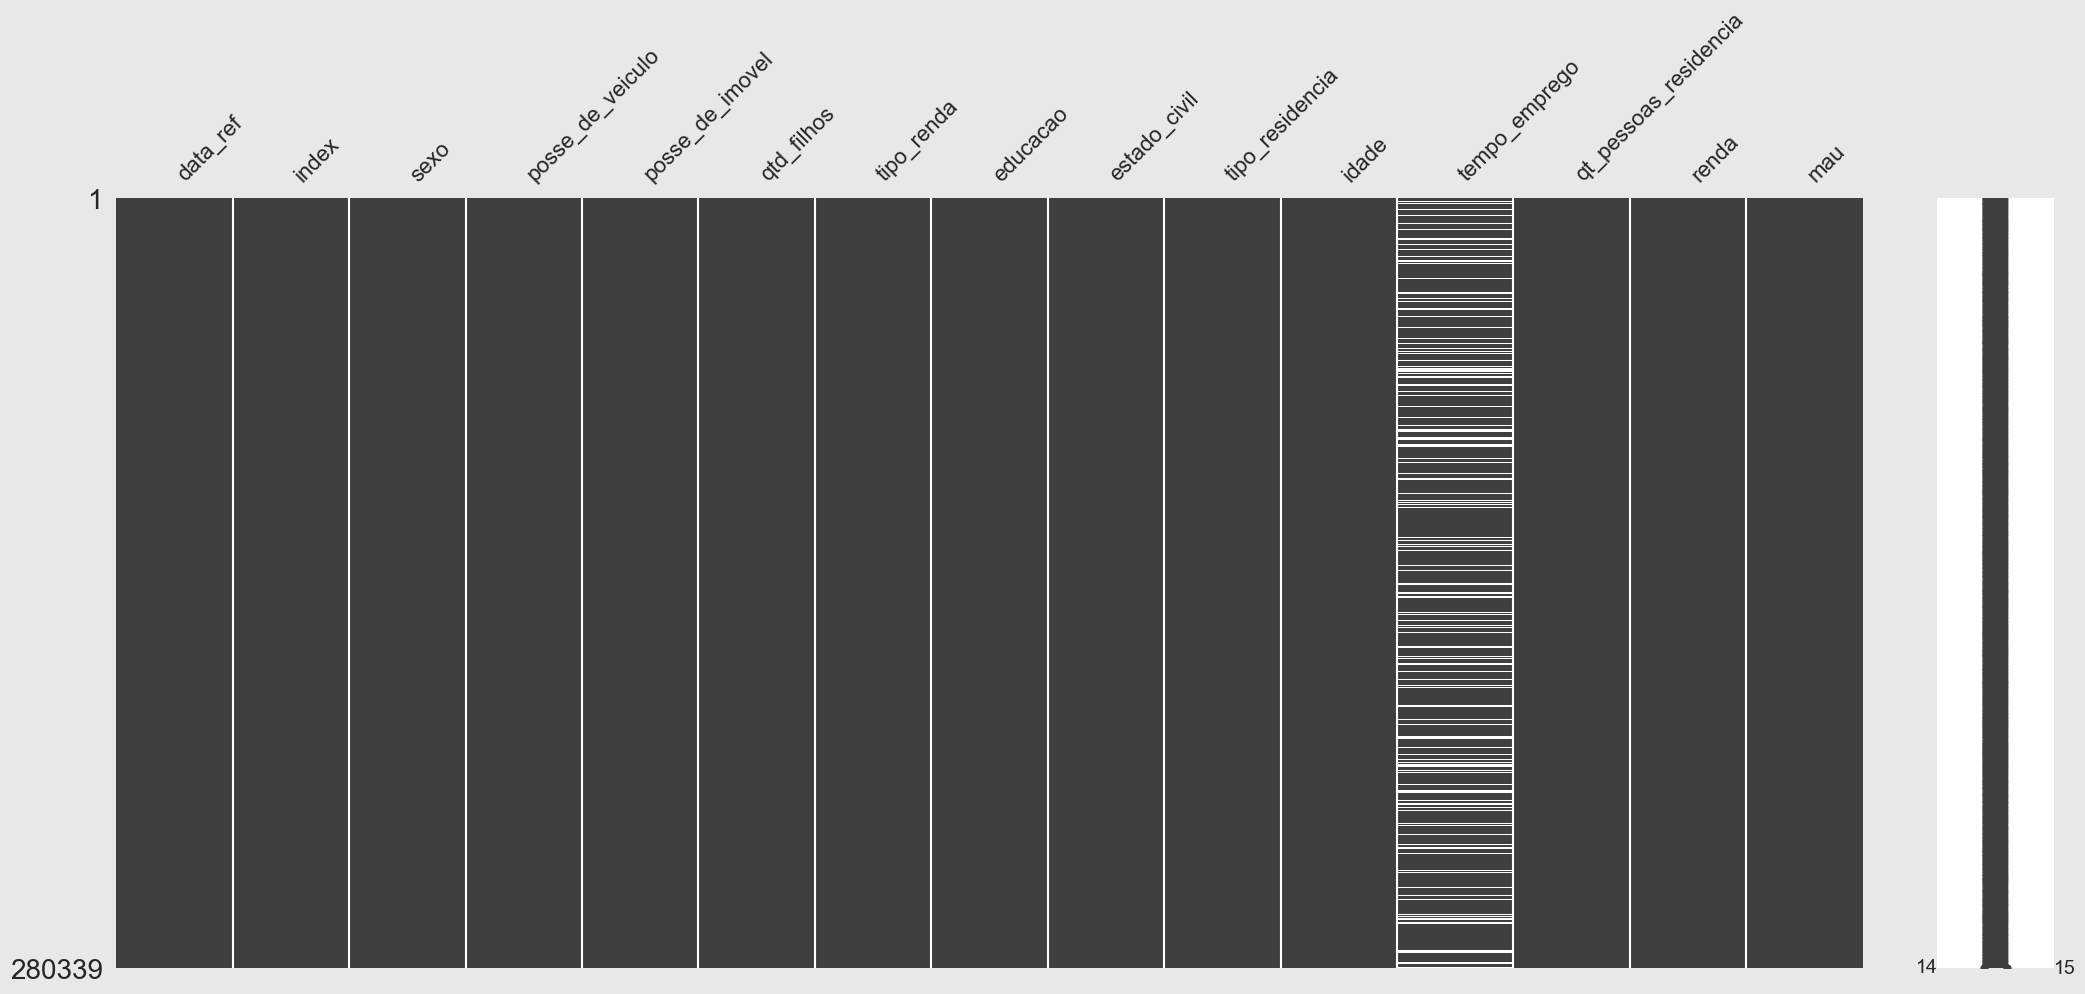

In [10]:
import missingno as msno
msno.matrix(df_)


In [ ]:
df_['month'] = df_['data_ref'].dt.month
df_['day_of_week'] = df_['data_ref'].dt.day_of_week

df_['tempo_emprego_faltante'] = df_['tempo_emprego'].isna().astype(int)

In [13]:
df_.groupby('tempo_emprego_faltante')['index'].count().to_frame().rename(columns={'index':'Frequency'})

,Frequency
tempo_emprego_faltante,
0,232730
1,47609


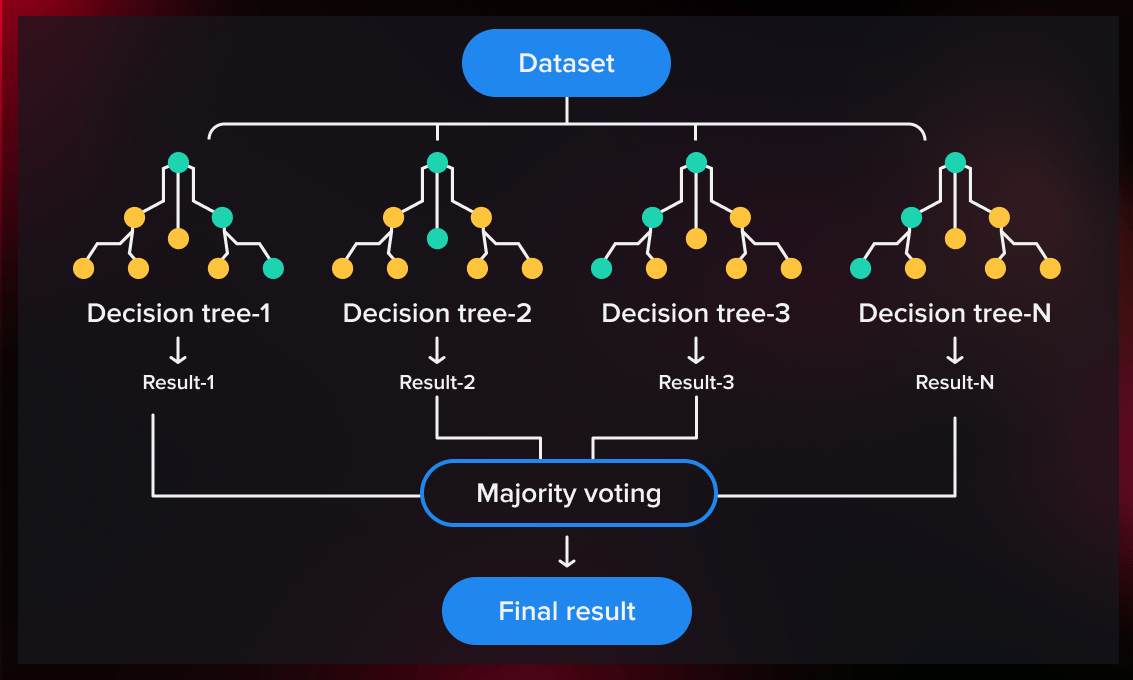

> reference: https://serokell.io/files/vz/vz1f8191.Ensemble-of-decision-trees.png

<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Machine Learning to fill missing values
</div>

>The process below describes the creation of a rando forest model to predict the values of the employment time variable. The cell below is a text cell, because we're not going to run this creation here, we're just going to call the picke file which is the prediction model.

```python

model = RandomForestRegressor()
model.get_params()

full_df = df_.dropna()
missing = df_[df_['tempo_emprego'].isna()]

X = full_df.drop(columns=['tempo_emprego','data_ref','index'])
y= full_df['tempo_emprego']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

model = RandomForestRegressor()

param = {
    'max_depth': [5,7,10],
    'n_estimators': [100, 200],
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,6],
    'ccp_alpha': np.random.rand(3)
}


grid = RandomizedSearchCV(
    estimator = model,
    param_distributions=param,
    verbose=2,
    cv = 3,

).fit(X_train,y_train)

best_model = grid.best_estimator_


best_model

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

faltantes_idx = df_['tempo_emprego'].isna()
valores_preditos = best_model.predict(df_[faltantes_idx].drop(columns=['tempo_emprego','data_ref']))
df_.loc[faltantes_idx, 'tempo_emprego'] = valores_preditos
df_.info()



with open('random_forest_tempo_emprego.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("Modelo salvo com sucesso!")

```


> 

In [14]:

with open('random_forest_tempo_emprego.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
print("Model uploaded successfully!")




Model uploaded successfully!


In [15]:
faltantes_idx = df_['tempo_emprego'].isna()
valores_preditos = loaded_model.predict(df_[faltantes_idx].drop(columns=['tempo_emprego','data_ref']))
df_.loc[faltantes_idx, 'tempo_emprego'] = valores_preditos
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280339 entries, 0 to 749998
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   data_ref                280339 non-null  datetime64[ns]
 1   index                   280339 non-null  int64         
 2   sexo                    280339 non-null  int64         
 3   posse_de_veiculo        280339 non-null  int64         
 4   posse_de_imovel         280339 non-null  int64         
 5   qtd_filhos              280339 non-null  int64         
 6   tipo_renda              280339 non-null  int32         
 7   educacao                280339 non-null  int32         
 8   estado_civil            280339 non-null  int32         
 9   tipo_residencia         280339 non-null  int32         
 10  idade                   280339 non-null  int64         
 11  tempo_emprego           280339 non-null  float64       
 12  qt_pessoas_residencia   280339 non-

<div style="background-color:#8f28ff; color:white; padding:10px; border-radius:5px; text-align:center; font-size:20px;">
    Feature Engenieer
</div>

In [16]:
df_['renda'].describe()

count    280339.000
mean      20474.304
std       72631.814
min         107.670
25%        2941.455
50%        6731.950
75%       16036.025
max     4083986.220
Name: renda, dtype: float64

In [17]:
df_['renda'] =  np.log1p(df_['renda']) 


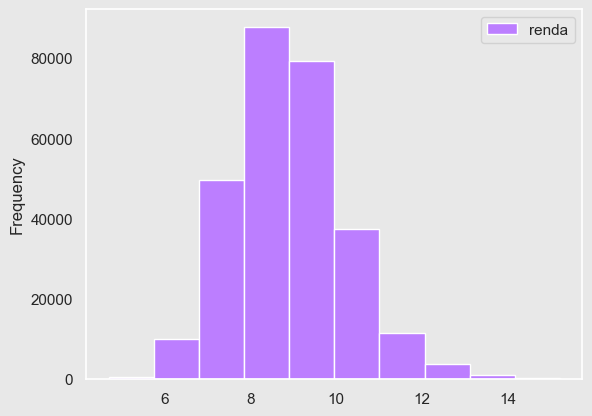

In [18]:
df_[['renda']].plot.hist(color='#bc7eff')
plt.grid(None)

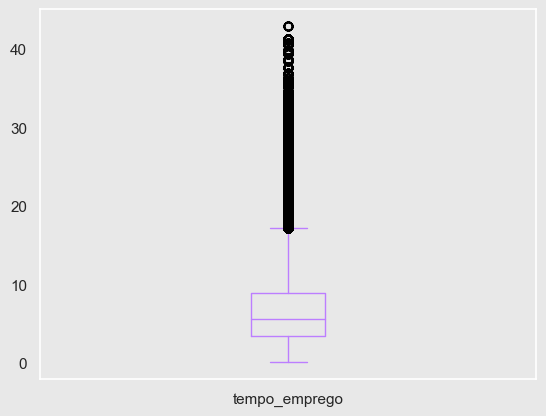

In [19]:
df_.tempo_emprego.plot.box(color='#bc7eff')
plt.grid(None)

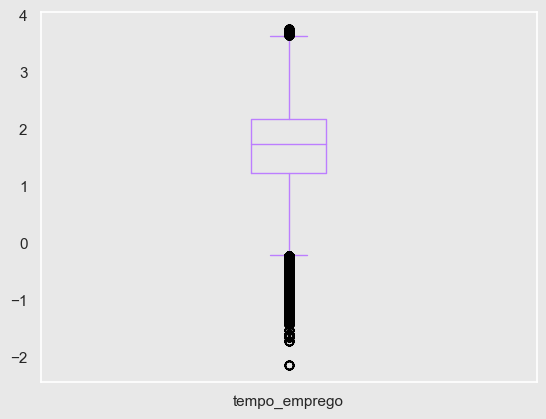

In [20]:
np.log(df_.tempo_emprego).plot.box(color='#bc7eff')
plt.grid(None)

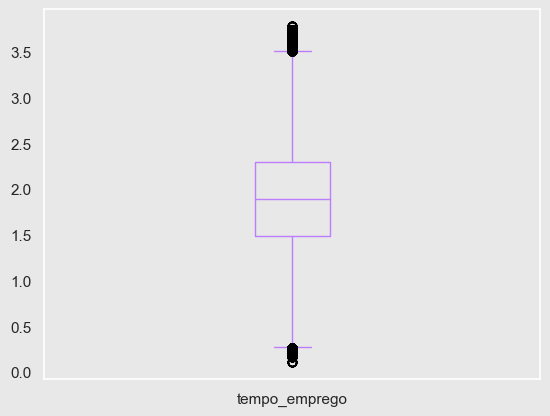

In [21]:
np.log1p(df_.tempo_emprego).plot.box(color='#bc7eff')
plt.grid(None)

In [22]:
df_['tempo_emprego'] = np.log1p(df_.tempo_emprego)


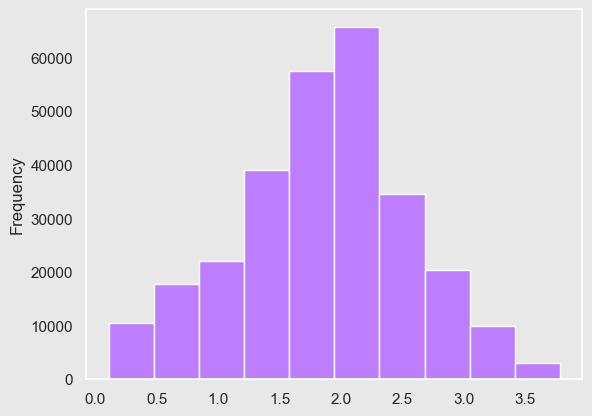

In [23]:
df_['tempo_emprego'].plot.hist(color='#bc7eff')
plt.grid(None)

<Axes: xlabel='tempo_emprego', ylabel='Count'>

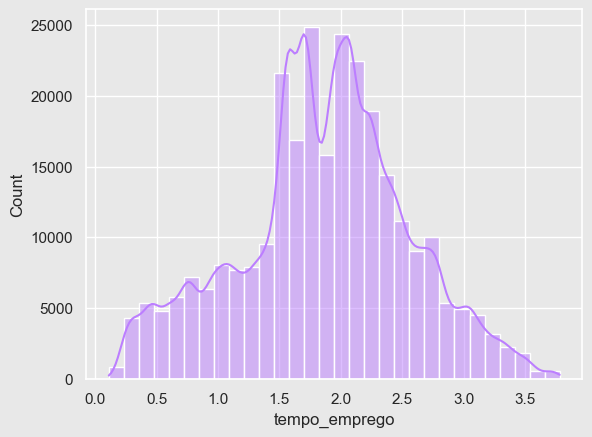

In [24]:
sns.histplot(data = df_,x='tempo_emprego',bins=30,kde=True,color='#bc7eff')

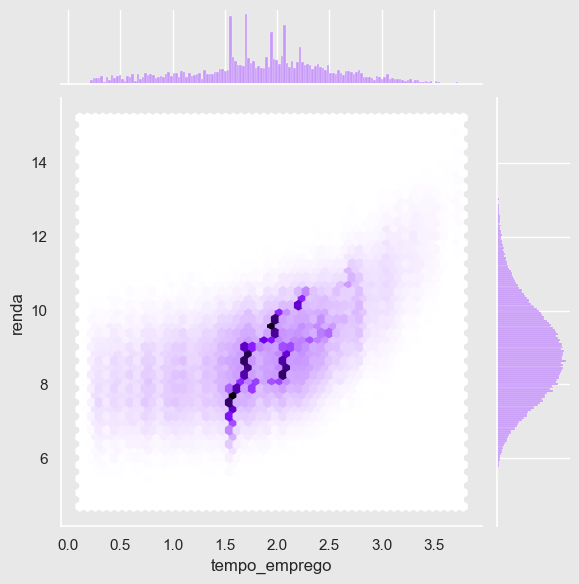

In [38]:
sns.jointplot(data=df_,x='tempo_emprego',y='renda', kind="hex",color='#bc7eff')
plt.grid(None)
plt.show()

In [26]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280339 entries, 0 to 749998
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   data_ref                280339 non-null  datetime64[ns]
 1   index                   280339 non-null  int64         
 2   sexo                    280339 non-null  int64         
 3   posse_de_veiculo        280339 non-null  int64         
 4   posse_de_imovel         280339 non-null  int64         
 5   qtd_filhos              280339 non-null  int64         
 6   tipo_renda              280339 non-null  int32         
 7   educacao                280339 non-null  int32         
 8   estado_civil            280339 non-null  int32         
 9   tipo_residencia         280339 non-null  int32         
 10  idade                   280339 non-null  int64         
 11  tempo_emprego           280339 non-null  float64       
 12  qt_pessoas_residencia   280339 non-

In [27]:
target = df_['mau'].copy()
df_ = df_.drop(columns=['mau'])

In [28]:
target.info()

<class 'pandas.core.series.Series'>
Index: 280339 entries, 0 to 749998
Series name: mau
Non-Null Count   Dtype
--------------   -----
280339 non-null  bool 
dtypes: bool(1)
memory usage: 2.4 MB


In [29]:
label = df_.drop(columns=['data_ref']).columns.tolist()

scaler = MinMaxScaler()
df_pad = scaler.fit_transform(df_.drop(columns=['data_ref']))
df_pad = pd.DataFrame(data=df_pad,columns=label)

df_pad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280339 entries, 0 to 280338
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   280339 non-null  float64
 1   sexo                    280339 non-null  float64
 2   posse_de_veiculo        280339 non-null  float64
 3   posse_de_imovel         280339 non-null  float64
 4   qtd_filhos              280339 non-null  float64
 5   tipo_renda              280339 non-null  float64
 6   educacao                280339 non-null  float64
 7   estado_civil            280339 non-null  float64
 8   tipo_residencia         280339 non-null  float64
 9   idade                   280339 non-null  float64
 10  tempo_emprego           280339 non-null  float64
 11  qt_pessoas_residencia   280339 non-null  float64
 12  renda                   280339 non-null  float64
 13  month                   280339 non-null  float64
 14  day_of_week         

In [30]:
df_pad['mau'] = target.reset_index(drop=True)


In [31]:
df_pad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280339 entries, 0 to 280338
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   280339 non-null  float64
 1   sexo                    280339 non-null  float64
 2   posse_de_veiculo        280339 non-null  float64
 3   posse_de_imovel         280339 non-null  float64
 4   qtd_filhos              280339 non-null  float64
 5   tipo_renda              280339 non-null  float64
 6   educacao                280339 non-null  float64
 7   estado_civil            280339 non-null  float64
 8   tipo_residencia         280339 non-null  float64
 9   idade                   280339 non-null  float64
 10  tempo_emprego           280339 non-null  float64
 11  qt_pessoas_residencia   280339 non-null  float64
 12  renda                   280339 non-null  float64
 13  month                   280339 non-null  float64
 14  day_of_week         

In [32]:
df_pad['data_ref'] = df_[['data_ref']].reset_index(drop=True)

In [33]:
out_of_time_pad = df_pad[df_pad['data_ref'] >= '2016-01-01']
data_2015 = df_pad[df_pad['data_ref'] < '2016']

In [34]:
out_of_time_pad.to_csv('out_of_time_pad.csv')
df_pad.to_csv('df_pad.csv')
data_2015.to_csv('data_2015.csv')

In [35]:
df_

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,month,day_of_week,tempo_emprego_faltante
0,2015-01-01,5733,1,0,0,0,2,1,2,1,43,2.064,1.000,7.831,1,3,0
21077,2015-01-01,3940,1,0,1,0,2,1,0,1,42,1.781,2.000,7.235,1,3,0
21074,2015-01-01,4022,0,0,0,2,0,1,0,1,26,1.533,4.000,7.585,1,3,0
21071,2015-01-01,16121,1,1,1,1,0,3,1,1,51,2.856,2.000,10.049,1,3,0
21067,2015-01-01,3935,1,0,1,1,0,1,3,1,33,1.326,3.000,7.418,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708483,2016-03-01,15026,1,1,0,1,4,3,0,1,39,2.830,3.000,8.526,3,1,0
708482,2016-03-01,2603,1,1,1,0,2,1,0,1,40,1.588,2.000,7.795,3,1,0
708481,2016-03-01,1201,1,1,1,2,2,3,0,1,32,2.181,4.000,7.324,3,1,0
708478,2016-03-01,15873,1,0,1,0,0,1,0,1,52,2.712,2.000,9.307,3,1,0
